In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.loader import HGTLoader
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from src.utils import cluster_acc
from src.data import read_data, normalize, construct_graph
from models.scGPCL import scGPCL
from models.scGPCL_MSE import scGPCL_MSE

We attach this notebook files to demonstrate reproducibility of our model.  
**config model** function loads our model **scGPCL**  
**evaluate_clustering_classification** function loads the trained weight and evaluate clustering performance.  
**visualize** function visualizes the t-SNE embedding from **scGPCL**

In [25]:
def config_model(adata, c_g_graph, n_clusters, device=0):
    model = scGPCL(c_g_graph.metadata(), adata.n_vars, n_clusters, device=device).to(device)
    gene_embedding = nn.Embedding(adata.n_vars, 64)
    loader = HGTLoader(c_g_graph, num_samples=[2048,1024], shuffle=False, input_nodes=('cell', torch.ones(adata.n_obs).bool()), batch_size=1024)
    
    batch = next(iter(loader))
    batch = batch.to(device)
    gene_emb = gene_embedding.weight[batch['gene'].n_id].to(device)
    batch['gene'].x = gene_emb
    model.encoder(batch)
    loader = HGTLoader(c_g_graph, num_samples=[2048,1024], shuffle=False, input_nodes=('cell', torch.ones(adata.n_obs).bool()), batch_size=1024)

    return model, gene_embedding, loader

In [26]:
def evaluate_clustering_performance(name, n_clusters, HVG, device=0):
    
    adata = read_data(name)
    adata = normalize(adata, HVG=HVG)
    c_g_graph = construct_graph(adata.raw.X, adata.X, adata.n_obs, adata.n_vars)
        
    weight_path = f'./weights/zinb_{name}.pt'
    weights = torch.load(weight_path)

    model, gene_embedding, loader = config_model(adata, c_g_graph, n_clusters, device=device)
    model.load_state_dict(weights['model_state_dict'])
    gene_embedding.load_state_dict(weights['gene_embedding_state_dict'])

    latent = model.predict_full_cell_rep(loader, gene_embedding)
    q = model.soft_assign(torch.tensor(latent).to(device))
    y_pred = torch.argmax(q, dim=1).data.cpu().numpy()

    nmi = normalized_mutual_info_score(adata.obs['Group'], y_pred)
    ca, _ , _ = cluster_acc(adata.obs['Group'], y_pred)
    ari = adjusted_rand_score(adata.obs['Group'], y_pred)    

    print("** {} --> NMI : {:.4f} / CA : {:.4f} / ARI : {:.4f} ** ".format(name, nmi, ca, ari))

In [24]:
def visualize(name, alpha=1.0):

    adata = read_data(name)
    path =  f'./t_SNE/{name}.csv'
    df = pd.read_csv(path)    

    bench_celltype = adata.obs['Group']
    cell_types = bench_celltype.values

    x = df['comp1']
    y = df['comp2']
    labels = np.unique(cell_types)

    colors = sns.color_palette("hls", len(labels))
    colors = np.array(colors)

    for label, color in zip(labels, colors):
        boolean = (cell_types==label)
        plt.scatter(x=x[boolean], y=y[boolean], color=color, label=label, alpha=alpha)

    plt.xticks([])
    plt.yticks([])

    plt.show()

# Cell Clustering

Because of the unavoidable randomness, below performance is not exactly same with **Figure 6**.  
However, you can check that it's enough to demonstrate the reproducibility of our model **scGPCL**.  

In [17]:
# Mouse Embryonic Stem cells
evaluate_clustering_performance(name='Mouse_ES', n_clusters=4, HVG=0.2)

** Mouse_ES --> NMI : 0.9923 / CA : 0.9985 / ARI : 0.9969 ** 


In [18]:
# Mouse bladder cells
evaluate_clustering_performance(name='MCA', n_clusters=16, HVG=0.2, device=0)

** MCA --> NMI : 0.7509 / CA : 0.6806 / ARI : 0.5870 ** 


In [26]:
# Zeisel
evaluate_clustering_performance(name='Zeisel', n_clusters=9, HVG=0.2, device=0)

** Zeisel --> NMI : 0.8349 / CA : 0.9295 / ARI : 0.8798 ** 


In [27]:
# Worm neuron cells
evaluate_clustering_performance(name='Worm_neuron_cells', n_clusters=10, HVG=0.2, device=0)

** Worm_neuron_cells --> NMI : 0.7563 / CA : 0.7040 / ARI : 0.5400 ** 


In [28]:
# 10X PBMC
evaluate_clustering_performance(name='10X_PBMC', n_clusters=8, HVG=0.2, device=0)

** 10X_PBMC --> NMI : 0.7758 / CA : 0.8228 / ARI : 0.7846 ** 


In [29]:
# Human kidney cells
evaluate_clustering_performance(name='Human_kidney_cells', n_clusters=11, HVG=0.2, device=0)

** Human_kidney_cells --> NMI : 0.8395 / CA : 0.8371 / ARI : 0.7596 ** 


In [30]:
# Shekhar mouse retina cells
evaluate_clustering_performance(name='Shekhar', n_clusters=19, HVG=1, device=0)

** Shekhar --> NMI : 0.8612 / CA : 0.8490 / ARI : 0.8587 ** 


Additionally, we also provide the variants of **scGPCL** which replace the ZINB-based reconstruction loss with the MSE-based reconstruction loss.  

In [2]:
def config_mse_model(adata, c_g_graph, n_clusters, device=0):
    model = scGPCL_MSE(c_g_graph.metadata(), adata.n_vars, n_clusters, device=device).to(device)
    gene_embedding = nn.Embedding(adata.n_vars, 64)
    loader = HGTLoader(c_g_graph, num_samples=[2048,1024], shuffle=False, input_nodes=('cell', torch.ones(adata.n_obs).bool()), batch_size=1024)
    
    batch = next(iter(loader))
    batch = batch.to(device)
    gene_emb = gene_embedding.weight[batch['gene'].n_id].to(device)
    batch['gene'].x = gene_emb
    model.encoder(batch)
    loader = HGTLoader(c_g_graph, num_samples=[2048,1024], shuffle=False, input_nodes=('cell', torch.ones(adata.n_obs).bool()), batch_size=1024)

    return model, gene_embedding, loader

In [3]:
def evaluate_clustering_performance(name, n_clusters, HVG, device=0):
    
    adata = read_data(name)
    adata = normalize(adata, HVG=HVG)
    c_g_graph = construct_graph(adata.raw.X, adata.X, adata.n_obs, adata.n_vars)
        
    weight_path = f'./weights/mse_{name}.pt'
    weights = torch.load(weight_path)

    model, gene_embedding, loader = config_mse_model(adata, c_g_graph, n_clusters, device=device)
    model.load_state_dict(weights['model_state_dict'])
    gene_embedding.load_state_dict(weights['gene_embedding_state_dict'])

    latent = model.predict_full_cell_rep(loader, gene_embedding)
    q = model.soft_assign(torch.tensor(latent).to(device))
    y_pred = torch.argmax(q, dim=1).data.cpu().numpy()

    nmi = normalized_mutual_info_score(adata.obs['Group'], y_pred)
    ca, _ , _ = cluster_acc(adata.obs['Group'], y_pred)
    ari = adjusted_rand_score(adata.obs['Group'], y_pred)    

    print("** {} --> NMI : {:.4f} / CA : {:.4f} / ARI : {:.4f} ** ".format(name, nmi, ca, ari))

In [23]:
# Mouse Embryonic Stem cells
evaluate_clustering_performance(name='Mouse_ES', n_clusters=4, HVG=0.2)

** Mouse_ES --> NMI : 0.9396 / CA : 0.9816 / ARI : 0.9546 ** 


In [24]:
# Mouse bladder cells
evaluate_clustering_performance(name='MCA', n_clusters=16, HVG=0.2, device=0)

** MCA --> NMI : 0.7612 / CA : 0.7141 / ARI : 0.6083 ** 


In [26]:
# Zeisel
evaluate_clustering_performance(name='Zeisel', n_clusters=9, HVG=0.2, device=0)

** Zeisel --> NMI : 0.8185 / CA : 0.9241 / ARI : 0.8637 ** 


In [27]:
# Worm neuron cells
evaluate_clustering_performance(name='Worm_neuron_cells', n_clusters=10, HVG=0.2, device=0)

** Worm_neuron_cells --> NMI : 0.7601 / CA : 0.6916 / ARI : 0.5571 ** 


In [28]:
# 10X PBMC
evaluate_clustering_performance(name='10X_PBMC', n_clusters=8, HVG=0.2, device=0)

** 10X_PBMC --> NMI : 0.7751 / CA : 0.8251 / ARI : 0.7826 ** 


In [29]:
# Human kidney cells
evaluate_clustering_performance(name='Human_kidney_cells', n_clusters=11, HVG=0.2, device=0)

** Human_kidney_cells --> NMI : 0.7827 / CA : 0.7854 / ARI : 0.6774 ** 


In [6]:
# Shekhar mouse retina cells
evaluate_clustering_performance(name='Shekhar', n_clusters=19, HVG=1, device=0)

** Shekhar --> NMI : 0.8238 / CA : 0.7766 / ARI : 0.7039 ** 


In [8]:
# Shekhar mouse retina cells
evaluate_clustering_performance(name='Shekhar', n_clusters=19, HVG=1, device=3)

** Shekhar --> NMI : 0.8950 / CA : 0.9061 / ARI : 0.9184 ** 


# Visualization

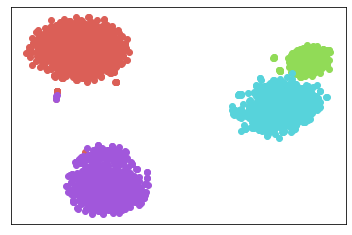

In [31]:
visualize(name='Mouse_ES')

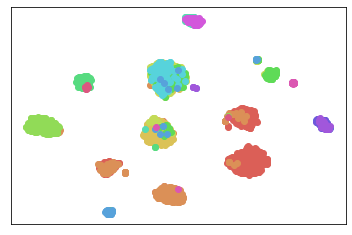

In [32]:
visualize(name='MCA')

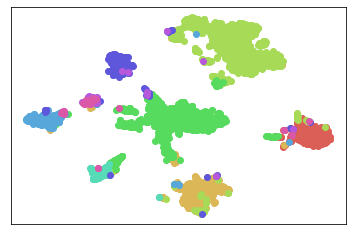

In [33]:
visualize(name='Zeisel')

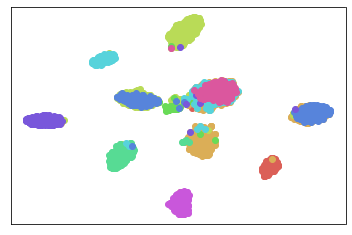

In [34]:
visualize(name='Worm_neuron_cells')

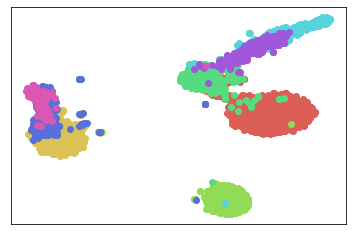

In [35]:
visualize(name='10X_PBMC')

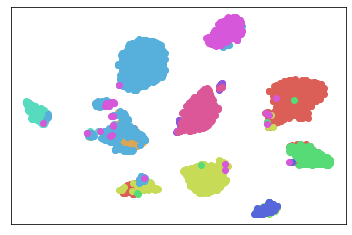

In [36]:
visualize(name='Human_kidney_cells')

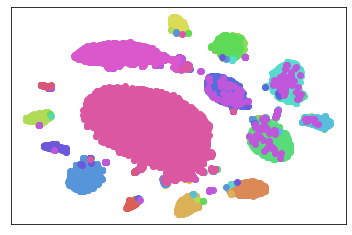

In [37]:
visualize(name='Shekhar')